# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» планирует расширить свою клиентскую базу с помощью нового мобильного приложения. Одной из ключевых функций приложения станет возможность расчёта рыночной стоимости автомобиля по его характеристикам. Это поможет пользователям оценить текущую стоимость своей машины на основе реальных рыночных данных, что сделает процесс купли-продажи прозрачнее и удобнее.

Нам предстоит построить модель, которая будет эффективно предсказывать рыночную стоимость автомобилей на основе их технических характеристик и комплектаций.

Перед нами стоит несколько задач:

- Подготовить и проанализировать данные о автомобилях, их характеристиках, комплектациях и ценах.
- Построить модели машинного обучения, которые смогут предсказывать стоимость автомобиля с высокой точностью.
- Сравнить модели по трём важным метрикам:
  1) качество предсказания;
  2) время обучения модели;
  3) время предсказания модели.
  
Данные, используемые для анализа, включают следующие признаки:

Категориальные признаки: тип кузова автомобиля (VehicleType), тип коробки передач (Gearbox), модель автомобиля (Model), тип топлива (FuelType), марка автомобиля (Brand) и информация о ремонтах (Repaired)   
Колличественные признаки: дата загрузки анкеты из базы данных (DateCrawled), год регистрации (RegistrationYear), мощность двигателя (л.с.) (Power), пробег в километрах (Kilometer), месяц регистрации (RegistrationMonth), дата создания анкеты (DateCreated), количество фотографий (NumberOfPictures), почтовый индекс владельца (PostalCode) и дата последней активности пользователя (LastSeen)   
Целевой признак для построения модели - цена автомобиля (Price).

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb
import phik
import warnings
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, GridSearchCV)
from sklearn.metrics import (mean_squared_error, roc_auc_score)
from catboost import CatBoostRegressor

# настройки
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

Для начала загрузим наш исходный датасет 

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
display(autos.head(5))
autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Выведем количество пропусков:

In [4]:
print(autos.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Мы сразу можем заметить, что в исходных данных есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType и Repaired, которые требуют обработки. Сначала приведём названия столбцов к нижнему регистру с помощью метода str.lower, затем проверим наличие полных дубликатов и выполним обработку пропущенных значений.

In [5]:
autos.columns = autos.columns.str.lower()
print(autos.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [6]:
print(autos.duplicated().sum())

4


Удалим полные дубликаты

In [7]:
autos = autos.drop_duplicates()
print(autos.duplicated().sum())

0


Если удалить все объекты с пропусками, мы потеряем очень много данных. 
Это может существенно повлиять на качество модели, так как значительная часть информации будет утрачена, что критично для построения точных предсказаний. Выведем уникальные значения, произведем замену пропусков для каждого признака и также проверим категориальные признаки на наличие ошибок

In [8]:
print(autos['vehicletype'].unique())
print(autos['vehicletype'].value_counts())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicletype, dtype: int64


Точно определить категорию для пропущенного значения в 'vehicletype' невозможно, поэтому используем заглушку и заменим пропуски на unknown

In [9]:
autos.fillna({'vehicletype': 'unknown'}, inplace=True)
print(autos['vehicletype'].value_counts())

sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicletype, dtype: int64


Сделаем то же самое для других признаков. 

In [10]:
print(autos['gearbox'].unique())
print(autos['gearbox'].value_counts())

['manual' 'auto' nan]
manual    268249
auto       66283
Name: gearbox, dtype: int64


Заменим все неизвестные типы коробки передач на значение unknown

In [11]:
autos.fillna({'gearbox': 'unknown'}, inplace=True)

In [12]:
print(autos['model'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

Модели range_rover и range_rover_sport могут считаться связанными, поскольку обе принадлежат к одной и той же линейке автомобилей Land Rover, поэтому переименуем range_rover_sport просто в range_rover

In [13]:
autos['model'] = autos['model'].replace(['range_rover_sport'], 'range_rover')

Как и выше, добавим неизвестные значения моделей, тип топлива и была машина в ремонте или нет в unknown

In [14]:
autos.fillna({'model': 'unknown'}, inplace=True)

In [15]:
print(autos['fueltype'].unique())
print(autos['fueltype'].value_counts())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64


In [16]:
# переименуем gasoline в petrol, поскольку эти значения оба обозначают "бензин"
autos['fueltype'] = autos['fueltype'].replace(['gasoline'],'petrol')

In [17]:
autos.fillna({'fueltype': 'unknown'}, inplace=True)

In [18]:
print(autos['repaired'].unique())
print(autos['repaired'].value_counts())

[nan 'yes' 'no']
no     247158
yes     36053
Name: repaired, dtype: int64


In [19]:
autos.fillna({'repaired': 'unknown'}, inplace=True)

Посмотрим, как обработались все пропуски

In [20]:
print(autos.isna().sum())

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64


Посмотрим на все оставшиеся признаки и проанализируем их

In [21]:
print(autos['brand'].unique())

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


Удалим следующие столбцы, которые не будут нужны для построения модели: datecrawled, registrationmonth, datecreated, numberofpictures, postalcode и lastseen. Эти признаки не оказывают влияния на цену автомобиля (наш целевой признак), так как не связаны с его техническими характеристиками или комплектацией. Их сохранение не добавит полезной информации для модели, поэтому они не представляют практической ценности для машинного обучения.

In [22]:
autos.drop(columns=['datecrawled', 'datecreated', 'numberofpictures','postalcode', 'lastseen', 'registrationmonth'],axis=1,inplace=True)

In [23]:
display(autos.head(5))

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


Для анализа и количественных признаков построим гистрограммы распределений и диаграммы размаха. После этого можно исключить выбросы, чтобы повысить качество данных.

In [24]:
autos.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0


1) Цена машины в евро - price

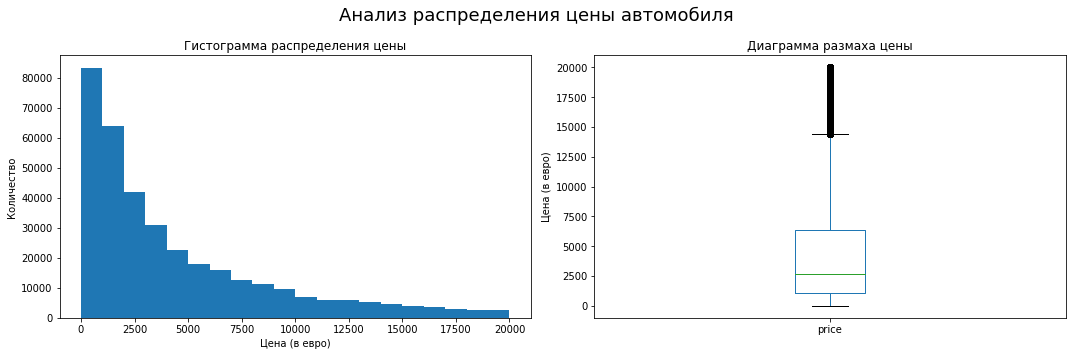

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Анализ распределения цены автомобиля', fontsize=18)

# Гистограмма распределения цены
autos['price'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма распределения цены')
axes[0].set_xlabel('Цена (в евро)')
axes[0].set_ylabel('Количество')

# Диаграмма размаха для цены
autos['price'].plot(kind='box', ax=axes[1])
axes[1].set_title('Диаграмма размаха цены')
axes[1].set_ylabel('Цена (в евро)')

plt.tight_layout()
plt.show()

Цена автомобиля не может равняться нулю, поэтому необходимо удалить все записи, в которых цена указана от 0 до 50 евро. Это позволяет избежать искажений в анализе и обеспечит более точные результаты при построении модели. Таким образом, мы отфильтруем данные, чтобы оставить только автомобили с действительными ценами, что также поможет улучшить качество предсказания модели в дальнейшем.

In [26]:
autos = autos.query('price > 50')

2) Год регистрации автомобиля - registrationyear

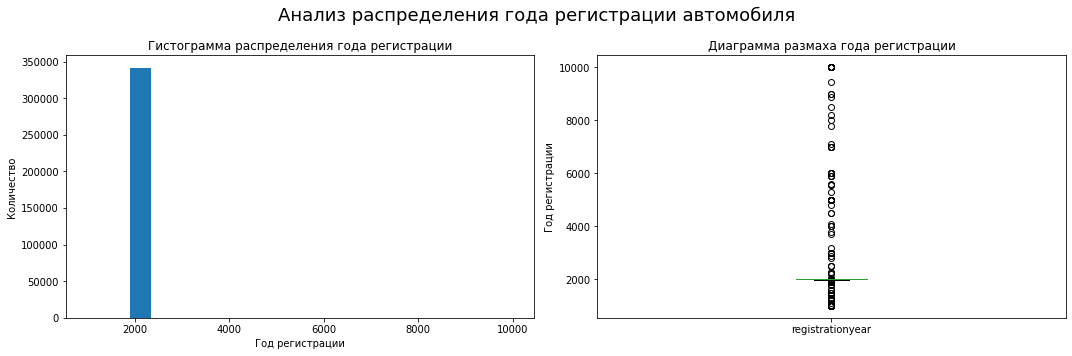

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Анализ распределения года регистрации автомобиля', fontsize=18)

# Гистограмма распределения года регистрации
autos['registrationyear'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма распределения года регистрации')
axes[0].set_xlabel('Год регистрации')
axes[0].set_ylabel('Количество')

# Диаграмма размаха для года регистрации
autos['registrationyear'].plot(kind='box', ax=axes[1])
axes[1].set_title('Диаграмма размаха года регистрации')
axes[1].set_ylabel('Год регистрации')

plt.tight_layout()
plt.show()

Судя по графикам, в данных есть значения для registrationyear, которые выглядят как выбросы, такие как 1000 и 9999. Эти значения явно выходят за разумные границы (автомобиль не мог быть зарегистрирован до 1800-х годов или после 2016 года). Исключим такие аномалии и оставить только реалистичные значения года регистрации автомобиля, например, от 1960 до 2016 года.

In [28]:
autos = autos[(autos['registrationyear'] >= 1960) & (autos['registrationyear'] <= 2016)]
print(autos['registrationyear'].describe())

count    327610.000000
mean       2002.664513
std           6.653777
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64


3) Мощность автомобиля (л. с.) - power

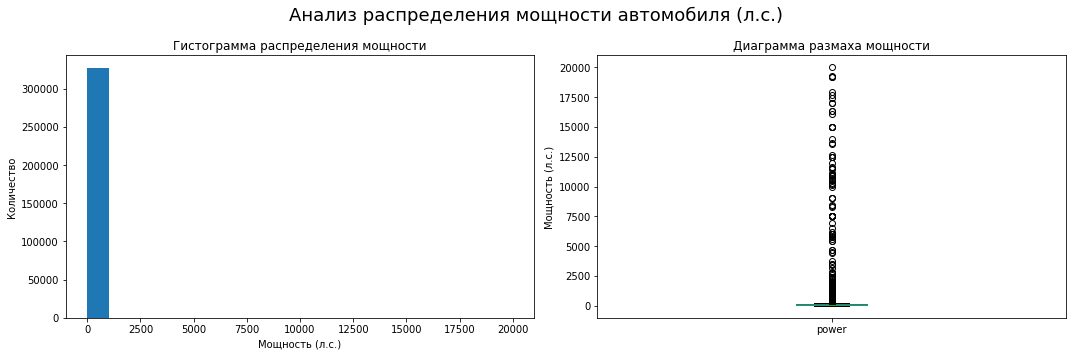

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Анализ распределения мощности автомобиля (л.с.)', fontsize=18)

# Гистограмма распределения мощности
autos['power'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма распределения мощности')
axes[0].set_xlabel('Мощность (л.с.)')
axes[0].set_ylabel('Количество')

# Диаграмма размаха для мощности
autos['power'].plot(kind='box', ax=axes[1])
axes[1].set_title('Диаграмма размаха мощности')
axes[1].set_ylabel('Мощность (л.с.)')

plt.tight_layout()
plt.show()

Судя по графикам у мощности автомобилей, имеются явные выбросы, так как значения мощности варьируются от 0 до 20,000 л.с. Обычно, диапазон реальной мощности автомобилей составляет от 40 до 650 л.с. для легковых автомобилей. Такие значения, как 0 л.с. и 20,000 л.с., могут свидетельствовать об ошибках ввода данных или неточностях. Укажем значения мощности меньше 650 л.с. но больше 40 л.с.

In [30]:
autos = autos[(autos['power'] > 40) & (autos['power'] <= 650)]

4) Пробег автомобиля (км) - kilometer

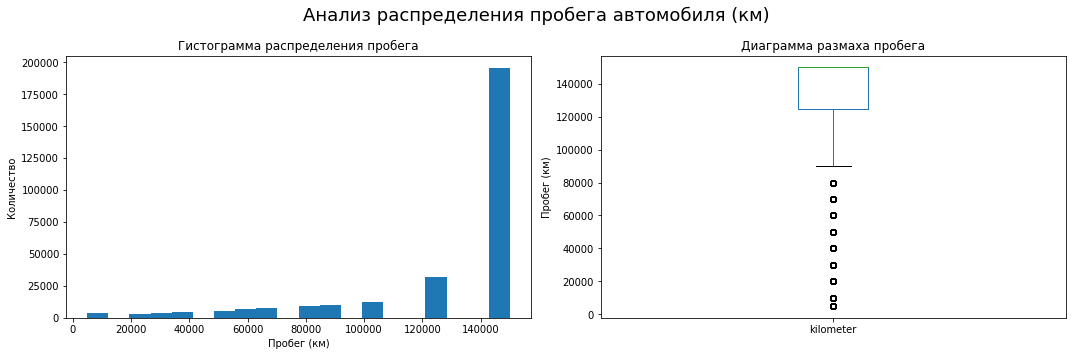

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Анализ распределения пробега автомобиля (км)', fontsize=18)

# Гистограмма распределения пробега
autos['kilometer'].plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('Гистограмма распределения пробега')
axes[0].set_xlabel('Пробег (км)')
axes[0].set_ylabel('Количество')

# Диаграмма размаха для пробега
autos['kilometer'].plot(kind='box', ax=axes[1])
axes[1].set_title('Диаграмма размаха пробега')
axes[1].set_ylabel('Пробег (км)')

plt.tight_layout()
plt.show()

In [32]:
autos['kilometer'].value_counts()

150000    195460
125000     31641
100000     12718
90000      10229
80000       8942
70000       7725
60000       6738
50000       5565
40000       4424
30000       3811
20000       3176
5000        2692
10000        870
Name: kilometer, dtype: int64

Согласно данным и этим графикам, можно заметить, что пробег большинства автомобилей сконцентрирован на уровне 150,000 км, что может указывать на то, что это распространённый пробег для подержанных автомобилей в нашем наборе данных. Оставим все данные по километражу и позволим модели лучше учесть особенности рынка подержанных автомобилей, тем самым улучшим точность прогнозов.

После анализа признаков можно провести корреляционный анализ для оценки взаимосвязей между ними. Построим матрицу корреляции коэффициента Фи

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer']


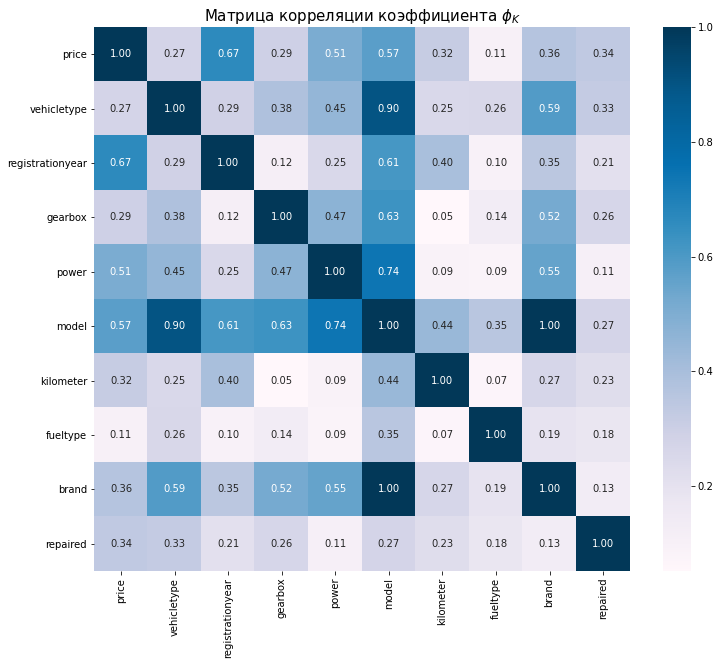

In [33]:
# построим матрицу корреляции коэффициента Фи'

selected_columns = ['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'fueltype', 'brand', 'repaired']
autos_subset = autos[selected_columns]

# Вычисляем матрицу корреляции с помощью phik
autos_phik = autos_subset.phik_matrix()

# Визуализация матрицы корреляции
plt.figure(figsize=(12, 10))
sns.heatmap(autos_phik, annot=True, fmt='.2f', cmap='PuBu', cbar=True)
plt.title('Матрица корреляции коэффициента $\phi_K$', fontsize=15)
plt.show()

Мы сразу можем заметить, что между признаками model и brand наблюдается полная корреляция (1.00). Это указывает на то, что наши данные пересекаются: для каждой модели соответствует только один конкретный бренд. Также признак model с признаком vehicletype имеет высокую корреляцию (0.898), что, вероятно, связано с тем, что большинство моделей автомобилей выпускаются в определенном варианте кузова, создавая взаимосвязь между этими признаками. Поэтому лучше удалить признак model, так как brand уже достаточно полно передаёт информацию о моделях, что поможет избежать избыточности данных и уменьшить риск мультиколлинеарности.

Кроме того, между ценой price и мощностью power автомобиля существует умеренная положительная корреляция (0.5), что указывает на то, что увеличение мощности автомобиля связано с повышением его цены. Значит, автомобили с более мощными двигателями часто имеют более высокую стоимость.

Также между ценой price и годом регистрации registrationyear заметная корреляция и она составляет 0.66, что скорее всего говорит нам о том, что более новые автомобили, как правило, стоят дороже.

Как и у model, мы видим заметную корреляцию между признаками brand и vehicletype (0.59) и она может быть объяснена тем, что определенные бренды выпускают машины, которые чаще представлены в определенных типах кузова. Вдобавок, умеренная корреляция между brand и power (0.55) и между brand и gearbox (0.52) говорит о том, что определенные марки имеют тенденцию к производству автомобилей с определенной мощностью и коробкой передач.

Оставшиеся признаки демонстрируют либо немного заметные, или же слабо выраженные корреляционные связи между друг другом.

In [34]:
# уберем признак model
autos.drop(columns=['model'],axis=1,inplace=True)

После всех преобразований опять перепроверим на дубликаты, и если они есть, удалим их

In [35]:
print(autos.duplicated().sum())

45397


In [36]:
autos = autos.drop_duplicates()
print(autos.duplicated().sum())

0


Итак, по итогу 1 шага работы можно сделать небольшие выводы:
Мной были выполнены несколько этапов, которые обеспечили качество и полноту набора данных для дальнейшего анализа и построения модели. 

Для начала мы загрузили и провели первичный анализ данных. Датасет был загружен, и мы выявили пропуски в нескольких столбцах: VehicleType, Gearbox, Model, FuelType и Repaired. Для обработки пропусков мы заменили их на значение "unknown", что позволило сохранить структуру данных без значительной потери информации.
После мы обнаружили и удалили 4 полных дубликата, чтобы избежать искажения результатов анализа.
Далее были исключены столбцы, которые не влияют на наш целевой признак на цену автомобиля (datecrawled, registrationmonth, datecreated, numberofpictures, postalcode и lastseen). Эти признаки не имели практической ценности для модели, и их сохранение могло бы лишь усложнить процесс машинного обучения.

Следующим шагом мы провели анализ количественных признаков и выявили аномалии в некоторых данных:
 - Цена автомобиля (price): Удалены записи с ценой меньше 50 евро, чтобы избежать искажений в анализе.
 - Год регистрации (registrationyear): Исключены нереалистичные значения года регистрации машины (например, 1000 и 9999), что позволило оставить только приемлемые данные (от 1960 года до 2016).
 - Мощность автомобиля (power): Мощность автомобиля мы указали в диапазоне от 40 л.с. до 650 л.с.

В заключение, мы построили матрицу корреляции Фи и провели корреляционный анализ, который выявил следующие результаты: мы обнаружили полную корреляцию (1.00) между признаками model и brand, что указывает на дублирование данных: каждой модели соответствует только один бренд. Также присутствовала высокая корреляция (0.898) между model и vehicletype была связана с тем, что большинство моделей выпускались в определённых вариантах кузова. Поэтому мы решили удалить признак model, поскольку brand уже достаточно отражал информацию о моделях и помогал избежать избыточности. 
Также мы обнаружили умеренную положительную корреляцию (0.5) между ценой price и мощностью power, что указывает на то, что более мощные автомобили, как правило, имеют более высокую стоимость. Заметная корреляция (0.66) между price и годом регистрации registrationyear свидетельствовала о том, что более новые автомобили, как правило, стоили дороже. Кроме того, присутствовала корреляция (0.59) между brand и vehicletype, что объясняется тем, что определённые бренды производят автомобили, соответствующие определённым типам кузова. Умеренные корреляции (0.55) между brand и power, а также (0.52) между brand и gearbox указывали на то, что некоторые марки выпускают автомобили с определённой мощностью и типом коробки передач. Остальные признаки показывают либо незначительные, либо слабые корреляционные связи между собой.
И в конце мы перепроверили наши данные на наличие дубликатов с последующим их удалением.

В результате проведенных действий мы подготовили данные для дальнейшего анализа и построения предсказательной модели. Проведенные шаги обеспечили целостность и качество набора данных, что создает надежную основу для эффективного анализа и более точных предсказаний в будущем.

## Обучение моделей

Далее для начала необходимо разделить датасет на тренировочную и тестовую выборки.

In [37]:
# Разделим данные на признаки и целевой признак
X = autos.drop('price', axis=1)
y = autos['price']

In [38]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

**1. Модель LightGBM**

In [39]:
X_train_lgbm = X_train.copy()
y_train_lgbm = y_train.copy()
X_test_lgbm = X_test.copy()
y_test_lgbm = y_test.copy()

In [40]:
cat_features = ['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']
for col in cat_features:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')

In [41]:
model_1 = lgb.LGBMRegressor(random_state=RANDOM_STATE)

param_grid = {'num_leaves': [100,150],'learning_rate':[0.2, 0.4, 0.5, 0.8]}

grid_search_lgbm=GridSearchCV(estimator=model_1,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

grid_search_lgbm.fit(X_train_lgbm, y_train_lgbm)

lgbm_params = grid_search_lgbm.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lgbm_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (grid_search_lgbm.best_score_ * -1))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END learning_rate=0.2, num_leaves=100;, score=-1669.114 total time= 1.0min
[CV 2/3] END learning_rate=0.2, num_leaves=100;, score=-1647.249 total time= 1.3min
[CV 3/3] END learning_rate=0.2, num_leaves=100;, score=-1663.646 total time= 4.4min
[CV 1/3] END learning_rate=0.2, num_leaves=150;, score=-1661.994 total time= 1.2min
[CV 2/3] END learning_rate=0.2, num_leaves=150;, score=-1641.041 total time= 1.7min
[CV 3/3] END learning_rate=0.2, num_leaves=150;, score=-1657.573 total time= 3.4min
[CV 1/3] END learning_rate=0.4, num_leaves=100;, score=-1688.532 total time= 1.9min
[CV 2/3] END learning_rate=0.4, num_leaves=100;, score=-1670.109 total time= 1.8min
[CV 3/3] END learning_rate=0.4, num_leaves=100;, score=-1687.092 total time= 2.1min
[CV 1/3] END learning_rate=0.4, num_leaves=150;, score=-1688.913 total time=  50.9s
[CV 2/3] END learning_rate=0.4, num_leaves=150;, score=-1665.443 total time=   8.0s
[CV 3/3] END lea

In [42]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

lgbm_model = lgb.LGBMRegressor(num_leaves = lgbm_params['num_leaves'], learning_rate = lgbm_params['learning_rate'], random_state=RANDOM_STATE)
lgbm_model.fit(X_train_lgbm, y_train_lgbm)

# Время обучения
end = time.time()
time_lgbm_fit =end-start
print(f"Время обучения модели LightGBM на тренировочной выборке: {time_lgbm_fit:.2f} секунд")

Время обучения модели LightGBM на тренировочной выборке: 10.60 секунд
CPU times: user 10.1 s, sys: 92.7 ms, total: 10.2 s
Wall time: 10.6 s


In [43]:
%%time
# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgbm = lgbm_model.predict(X_test_lgbm)
end_time = time.time()
prediction_time_lgbm = end_time - start_time
print(f"Время предсказания модели LightGBM: {prediction_time_lgbm:.2f} секунд")

Время предсказания модели LightGBM: 0.60 секунд
CPU times: user 599 ms, sys: 0 ns, total: 599 ms
Wall time: 600 ms


Лучшие параметры LightGBM: learning_rate: 0.2, num_leaves: 150. Качество модели на кросс-валидации: 1653.53. Найденое время обучение и предсказания, а также и этот качество модели на кросс-валидации будем в дальнейшем сравнивать с другими моделями, чтобы выбрать лучшую модель по трем критериям.

**2. Модель CatBoostRegressor**

In [44]:
X_train_cbr = X_train.copy()
y_train_cbr = y_train.copy()
X_test_cbr = X_test.copy()
y_test_cbr = y_test.copy()

In [45]:
cat_features = ['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']
for col in cat_features:
    X_train_cbr[col] = X_train_cbr[col].astype('category')
    X_test_cbr[col] = X_test_cbr[col].astype('category')

In [46]:
model_2 = CatBoostRegressor(iterations=100, verbose=100)

param_grid_cbr = {
    'learning_rate': [0.1, 0.4, 0.9],
    'random_state': [42],
    'depth': [6, 8]
}

random_search_cbr = RandomizedSearchCV(
    model_2, 
    param_distributions=param_grid_cbr, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=3,
    cv=5,
    n_jobs=-1
)

random_search_cbr.fit(X_train_cbr, y_train_cbr, cat_features=cat_features)

cbr_params = random_search_cbr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", cbr_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_cbr.best_score_ * -1))

0:	learn: 4379.1614497	total: 152ms	remaining: 15s
99:	learn: 1818.4635953	total: 5.37s	remaining: 0us
0:	learn: 4382.5254697	total: 59.2ms	remaining: 5.86s
99:	learn: 1816.0669864	total: 5.15s	remaining: 0us
0:	learn: 4383.7909362	total: 59.6ms	remaining: 5.9s
99:	learn: 1817.6216584	total: 5.28s	remaining: 0us
0:	learn: 4386.2158921	total: 58.4ms	remaining: 5.78s
99:	learn: 1815.3909946	total: 5.34s	remaining: 0us
0:	learn: 4383.0904744	total: 59.5ms	remaining: 5.89s
99:	learn: 1816.0862672	total: 5.31s	remaining: 0us
0:	learn: 3570.3805268	total: 70.5ms	remaining: 6.98s
99:	learn: 1706.9121546	total: 5.41s	remaining: 0us
0:	learn: 3572.6861707	total: 59ms	remaining: 5.84s
99:	learn: 1699.6139918	total: 5.34s	remaining: 0us
0:	learn: 3571.2448379	total: 60ms	remaining: 5.93s
99:	learn: 1704.1060363	total: 5.36s	remaining: 0us
0:	learn: 3574.7167205	total: 60.1ms	remaining: 5.95s
99:	learn: 1695.9523152	total: 5.42s	remaining: 0us
0:	learn: 3571.5056182	total: 57.4ms	remaining: 5.68s


In [47]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

cbr_model = CatBoostRegressor(random_state = cbr_params['random_state'], learning_rate = cbr_params['learning_rate'], depth = cbr_params['depth'], iterations=100, verbose=100)
cbr_model.fit(X_train_cbr, y_train_cbr, cat_features=cat_features)

# Время обучения
end = time.time()
time_cbr_fit =end-start
print(f"Время обучения модели CatBoostRegressor на тренировочной выборке: {time_cbr_fit:.2f} секунд")

0:	learn: 2644.6085760	total: 109ms	remaining: 10.8s
99:	learn: 1590.4903439	total: 8.77s	remaining: 0us
Время обучения модели CatBoostRegressor на тренировочной выборке: 9.52 секунд
CPU times: user 8.68 s, sys: 102 ms, total: 8.78 s
Wall time: 9.52 s


In [48]:
%%time
# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_cbr = cbr_model.predict(X_test_cbr)
end_time = time.time()
prediction_time_cbr = end_time - start_time
print(f"Время предсказания модели CatBoostRegressor: {prediction_time_cbr:.2f} секунд")

Время предсказания модели CatBoostRegressor: 0.04 секунд
CPU times: user 27.3 ms, sys: 12.5 ms, total: 39.8 ms
Wall time: 37.9 ms


Мы провели обучение модели CatBoostRegressor с использованием оптимальных гиперпараметров: random_state установлен в 42, learning_rate равен 0.9, а depth составляет 8. Качество модели на кросс-валидации: 1725.89. Найденое время обучение и предсказания, а также и этот качество модели на кросс-валидации будем в дальнейшем сравнивать с другими моделями, чтобы выбрать лучшую модель по трем критериям.

**3. Модель LinearRegression**

In [49]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

In [50]:
ohe_columns = ['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']  
num_columns = ['registrationyear', 'power', 'kilometer']

In [51]:
ohe_columns = ['vehicletype', 'gearbox', 'fueltype', 'brand', 'repaired']
for col in ohe_columns:
    X_train_lr[col] = X_train_lgbm[col].astype('object')
    X_test_lr[col] = X_test_lgbm[col].astype('object')

In [52]:
# создадим пайплайн для OneHotEncoder:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

In [53]:
# Преобразователи для числовых данных
num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [54]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [55]:
pipe_final_lr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

In [56]:
# Гиперпараметры для LinearRegression
param_grid_lr = {
    'model': [LinearRegression()],
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__n_jobs': [1, -1]
}

random_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_distributions=param_grid_lr, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=8,
    n_jobs=-1
)

random_search_lr.fit(X_train_lr, y_train_lr)

lr_params = random_search_lr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lr_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_lr.best_score_ * -1))


Лучшие параметры: {'model__n_jobs': 1, 'model__fit_intercept': True, 'model__copy_X': True, 'model': LinearRegression(n_jobs=1)}
Метрика RMSE, полученная с помощью кросс валидации: 2831.7625260288282


In [57]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
lr_model = random_search_lr.best_estimator_

lr_model.fit(X_train_lr, y_train_lr)

# Время обучения
end = time.time()
time_lr_fit =end-start
print(f"Время обучения модели LinearRegression на тренировочной выборке: {time_lr_fit:.2f} секунд")

Время обучения модели LinearRegression на тренировочной выборке: 3.11 секунд
CPU times: user 2.57 s, sys: 611 ms, total: 3.18 s
Wall time: 3.2 s


In [58]:
%%time
# Время предсказания модели LinearRegression
start_time = time.time()
y_pred_lr = lr_model.predict(X_test_lr)
end_time = time.time()
prediction_time_lr = end_time - start_time
print(f"Время предсказания модели LinearRegression: {prediction_time_lr:.2f} секунд")

Время предсказания модели LinearRegression: 0.16 секунд
CPU times: user 126 ms, sys: 46.8 ms, total: 172 ms
Wall time: 156 ms


Мы провели обучение модели LinearRegression с использованием оптимальных гиперпараметров: fit_intercept установлен в True, copy_X равен True, а n_jobs составляет 1. Качество модели на кросс-валидации: 2831.76. Найденное время обучения и предсказания, а также это качество модели на кросс-валидации будут в дальнейшем сравниваться с другими моделями, чтобы выбрать лучшую модель по трем критериям.

**4. Модель DecisionTreeRegressor**

In [59]:
X_train_dt = X_train.copy()
y_train_dt = y_train.copy()
X_test_dt = X_test.copy()
y_test_dt = y_test.copy()

In [60]:
pipe_final_dt = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [61]:
# Гиперпараметры для DecisionTreeRegressor
param_grid_dt = {
    'model__max_depth': [5, 10, 20], 
    'model__min_samples_split': [2, 5]
}

random_search_dt = RandomizedSearchCV(
    pipe_final_dt, 
    param_distributions=param_grid_dt, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=5,  
    cv=3,     
    n_jobs=-1  
)

random_search_dt.fit(X_train_dt, y_train_dt)

dt_params = random_search_dt.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", dt_params)
print("Метрика RMSE, полученная с помощью кросс валидации:", (random_search_dt.best_score_ * -1))


Лучшие параметры: {'model__min_samples_split': 5, 'model__max_depth': 20}
Метрика RMSE, полученная с помощью кросс валидации: 1979.0440976137427


In [62]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
dt_model = random_search_dt.best_estimator_

dt_model.fit(X_train_dt, y_train_dt)

# Время обучения
end = time.time()
time_dt_fit =end-start
print(f"Время обучения модели DecisionTreeRegressor на тренировочной выборке: {time_dt_fit:.2f} секунд")

Время обучения модели DecisionTreeRegressor на тренировочной выборке: 1.86 секунд
CPU times: user 1.72 s, sys: 141 ms, total: 1.86 s
Wall time: 1.87 s


In [63]:
%%time
# Время предсказания модели DecisionTreeRegressor
start_time = time.time()
y_pred_dt = dt_model.predict(X_test_dt)
end_time = time.time()
prediction_time_dt = end_time - start_time
print(f"Время предсказания модели DecisionTreeRegressor: {prediction_time_dt:.2f} секунд")

Время предсказания модели DecisionTreeRegressor: 0.12 секунд
CPU times: user 109 ms, sys: 4.11 ms, total: 113 ms
Wall time: 119 ms


Мы обучили модель DecisionTreeRegressor, используя оптимальные гиперпараметры: min_samples_split установлен на 5, а max_depth составляет 20. Качество модели на кросс-валидации составило 1979.04. Найденное время обучения и предсказания, а также это значение метрики будут сравниваться с другими моделями, чтобы выбрать наилучший вариант по трем критериям.

Итак, в этой части работы мы обучили несколько моделей машинного. Для каждой из моделей были проведены подбор и настройка гиперпараметров, что позволило улучшить качество предсказаний. В итоге нами были рассмотрены следующие модели: LightGBM, LinearRegression, DecisionTreeRegressor и CatBoostRegressor. Мы использовали кросс-валидацию для нахождения оптимальных гиперпараметров модели и определения ее качества. Затем мы измерили время обучения модели на всей тренировочной выборке. После этого также замерили время предсказания модели на тестовой выборке, однако результаты тестирования не выводили на экран. Теперь мы можем приступать к анализу всех 4х моделей и выбору лучшей из них.

## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей.

In [64]:
lr_rmse_train = random_search_lr.best_score_ * -1
lgbm_rmse_train = grid_search_lgbm.best_score_ * -1
cbr_rmse_train = random_search_cbr.best_score_ * -1
dt_rmse_train = random_search_dt.best_score_ * -1

In [65]:
# Создание DataFrame с нашими результатами
results = pd.DataFrame({
    'Модель': ['Linear Regression', 'LightGBM', 'CatBoostRegressor', 'DecisionTreeRegressor'],
    'RMSE': [lr_rmse_train, lgbm_rmse_train, cbr_rmse_train, dt_rmse_train],
    'Время предсказания (сек)': [prediction_time_lr, prediction_time_lgbm, prediction_time_cbr, prediction_time_dt],
    'Время обучения (сек)': [time_lr_fit, time_lgbm_fit, time_cbr_fit, time_dt_fit]  
})

# Вывод результатов
results

,Модель,RMSE,Время предсказания (сек),Время обучения (сек)
0,Linear Regression,2831.762526,0.155843,3.108680
1,LightGBM,1653.535839,0.599036,10.600267
2,CatBoostRegressor,1725.892404,0.037716,9.524440
3,DecisionTreeRegressor,1979.044098,0.118675,1.864751


В данной таблице представлены результаты оценки качества и времени работы 4х моделей для прогнозирования. Мы сравнили модели по метрике RMSE и времени, затрачиваемому на обучение и предсказание. Далее определим, какая из них наиболее эффективена для нашей задачи. 
 - **Linear Regression**: RMSE равно 2831.76 — это наибольший результат среди всех моделей, что указывает на низкое качество предсказаний. Время предсказания достоточно быстрое, что делает модель подходящей для задач, где требуется быстрая обработка. Также у модели относительно быстрое время обучения.
 - **LightGBM**: RMSE равно 1653.54 — это лучшая метрика среди всех моделей, показывающая высокую точность предсказаний. Время предсказания и время обучения больше, чем у Linear Regression, но все еще показатели остаются приемлемыми.
 - **CatBoostRegressor**: RMSE равно 1725.89 — хорошее качество предсказаний, хотя и немного хуже, чем у LightGBM. Наименьшее время предсказания, что делает его очень эффективным. Время обучения сопоставимо с LightGBM, что может быть приемлемым для сложных задач.
 - **DecisionTreeRegressor**: RMSE равно 1979.04 — качество предсказаний находится между Linear Regression и CatBoost. Время предсказания среднее, больше, чем у CatBoost, но меньше, чем у LightGBM. Самое быстрое время обучения среди всех моделей.
 
LightGBM показывает наилучшие показатели по метрике RMSE, что указывает на его способность эффективно моделировать данные. Хотя время обучения и предсказания выше, чем у некоторых других моделей, его высокая точность делает его предпочтительным выбором в случаях, когда критически важно качество предсказаний. Это особенно важно в сценариях, где ошибки могут иметь серьезные последствия, поэтому предпочтение отдается моделям, которые обеспечивают максимальную надежность.

Таким образом, LightGBM следует выбрать в качестве финальной модели, так как она продемонстрировала отличные результаты по всем трем параметрам, обеспечивая оптимальное сочетание качества предсказаний и эффективности. 

Теперь посмотрим значения RMSE у нашей лучшей модели на тестовой выборке

In [66]:
# Оценка качества модели LightGBM на тестовой выборке
rmse_test_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print("RMSE LightGBM на тестовой выборке: %.2f" % rmse_test_lgbm)

RMSE LightGBM на тестовой выборке: 1635.29


Пониженное значение RMSE на тестовой выборке по сравнению с кросс-валидацией может указывать на то, что модель не только хорошо подходит для данных, на которых она обучалась, но и способна точно предсказывать на новых данных. Это является положительным признаком и свидетельствует о хорошем качестве модели.
Небольшая разница между значениями RMSE (1653.53 на тренировочных данных и 1635.29 на тестовой выборке) также говорит о том, что модель не переобучена и сохраняет свою эффективность на новых данных.

В данном шаге нашей работы мы провели оценку времени обучения, времени предсказания и качества четырех моделей, используемых для прогнозирования. Мы проанализировали такие модели, как LightGBM, LinearRegression, DecisionTreeRegressor и CatBoostRegressor. Результаты представлены в таблице, в которой сравниваются метрики RMSE и затраты времени на обучение и предсказание. На основе полученных данных мы определили наиболее эффективную модель для нашей задачи. 
  
Linear Regression: качество модели на кросс-валидации — 2831.76, что указывает на низкое качество предсказаний. Время предсказания быстрое, что может быть полезно, время обучения также относительно короткое.
  
LightGBM: качество модели на кросс-валидации — 1653.54, лучший результат среди моделей, демонстрирующий высокую точность предсказаний. Время предсказания и обучения выше, чем у линейной регрессии, но значения все еще приемлемы.
  
CatBoostRegressor: качество модели на кросс-валидации — 1725.89, хорошее качество предсказаний, хотя ниже, чем у LightGBM. Обладает наименьшим временем предсказания, а время обучения сопоставимо с LightGBM.

DecisionTreeRegressor: качество модели на кросс-валидации — 1979.04, качество предсказаний между Linear Regression и CatBoost. Время предсказания среднее: больше, чем у CatBoost и Linear Regression, но меньше, чем у LightGBM. Демонстрирует самое быстрое время обучения среди всех моделей.

**LightGBM** была выбрана в качестве окончательной лучшей модели, так как она показала превосходные результаты по всем трем критериям, обеспечивая оптимальное сочетание качества предсказаний и эффективности.

И в конце мы проанализировали значения RMSE для нашей лучшей модели на тестовой выборке. Пониженное значение RMSE на тестовой выборке по сравнению с кросс-валидацией свидетельствовало о том, что модель хорошо адаптировалась к данным, на которых она обучалась, и могла точно предсказывать на новых данных. Это является положительным показателем, подтверждающим высокое качество модели. Небольшая разница между значениями RMSE (1653.53 на тренировочных данных и 1635.29 на тестовой выборке) также подтверждала, что модель не переобучена и сохраняет свою эффективность на новых данных.

## Итоговый вывод

Итак, мы успешно выполнили несколько ключевых задач в рамках нашего проекта, что позволило нам создать и найти  эффективную модель для предсказания рыночной стоимости автомобилей. 

Для начала мы подготовили и проанализировали данные о автомобилях, их характеристиках, комплектациях и ценах. Мы загрузили данные, провели первичный анализ данных о характеристиках автомобилей, обработали пропуски. Пропуски были заменены на значение "unknown", что помогло сохранить структуру данных без потери информации. Затем мы исключили столбцы, не влияющие на целевой признак, чтобы обеспечить качество и целостность набора данных. В процессе подготовки данных нами также был проведен анализ различных признаков, в ходе которого выявили аномалии, после чего мы исключили или заменили нереалистичные значения и  оставили только те диапазоны значений, которые выглядят правдоподобно. После анализа признаков мы провели корреляционный анализ для оценки взаимосвязей между ними. Построили матрицу корреляции коэффициента Фи для того, чтобы определить признаки, которые сильно коррелируют друг с другом. Убрав сильно коррелирующий признак model, мы улучшили качество модели избежав мультиколлинеарности. И в конце, после всех преобразований, мы удалили полные дубликаты, чтобы избежать искажения результатов анализа. 
Все эти шаги помогли улучшить качество данных и создать надежную базу для дальнейшего анализа. 

Для каждой модели были выполнены подбор и настройка гиперпараметров, что способствовало улучшению качества предсказаний. В результате мы рассмотрели следующие модели: LightGBM, LinearRegression, DecisionTreeRegressor и CatBoostRegressor. Мы применили кросс-валидацию для определения оптимальных гиперпараметров и оценки качества моделей. Затем замерили время обучения каждой модели на всей тренировочной выборке, а также время предсказания 

И потом мы сравнили модели по трем важным метрикам: качество модели на кросс-валидации (RMSE), время обучения модели, время предсказания модели.

Мы проанализировали все модели и выявили, что модель Linear Regression имеет самое большое значение RMSE, поэтому она не подходит нам для решения поставленной задачи. CatBoostRegressor достигла хорошего качества RMSE, что свидетельствует о хорошем уровне предсказаний, хотя она несколько уступает LightGBM. Эта модель обладает наименьшим временем предсказания, а время обучения сопоставимо с LightGBM. DecisionTreeRegressor показала качество на уровне 1979.04, что находится между Linear Regression и CatBoost. Время предсказания средней продолжительности: больше, чем у CatBoost и линейной регрессии, но меньше, чем у LightGBM. Эта модель демонстрирует самое быстрое время обучения.

По итогу, модель LightGBM продемонстрировала лучшие результаты, достигнув минимального значения качества модели на кросс-валидации = 1653.54, что сделало её идеальным вариантом для решения этой задачи. Время обучения оказалось умеренным, что обеспечило отличное сочетание точности и эффективности. 

И в заключение, мы рассмотрели значения RMSE нашей лучшей модели на тестовой выборке. Более низкий RMSE на тестовой выборке по сравнению с кросс-валидацией свидетельствовал о том, что модель хорошо адаптировалась к обучающим данным и способна делать точные предсказания на новых данных. Это является положительным знаком, подтверждающим высокое качество модели. Кроме того, небольшая разница между RMSE (1653.53 на тренировочных данных и 1635.29 на тестовой выборке) подтверждала, что модель не переобучена и сохраняет свою эффективность на новых данных. Таким образом, модель LightGBM способна наиболее точно прогнозировать рыночную стоимость автомобилей, основываясь на их технических характеристиках и комплектациях.